In [1]:
#!pip install numpy pandas torch matplotlib seaborn scikit-learn

In [2]:
!pip install numpy
!pip install pandas
!pip install torch
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Core libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Load your volatility index data
data = pd.read_csv('DayByDay96_Volatility 10 Index.csv')

print("Dataset Shape:", data.shape)
print(f"Days: {data.shape[0]}, Intraday measurements: {data.shape[1]}")
print(f"\nData range: [{data.values.min():.2f}, {data.values.max():.2f}]")
print(f"Mean volatility: {data.values.mean():.2f}")
print(f"Std deviation: {data.values.std():.2f}")

Dataset Shape: (3103, 96)
Days: 3103, Intraday measurements: 96

Data range: [5852.97, 11077.68]
Mean volatility: 7358.27
Std deviation: 1294.24


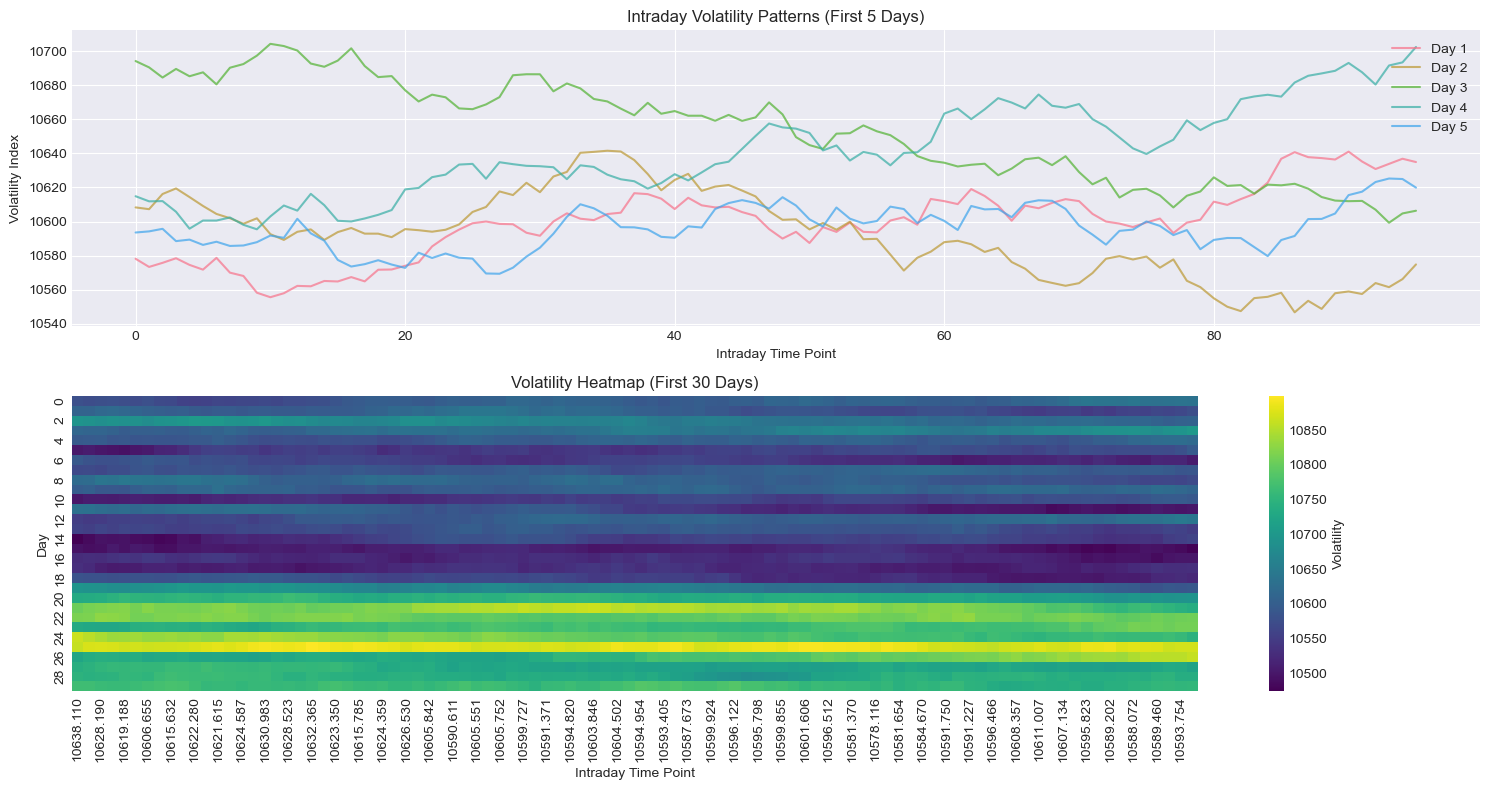

In [5]:
# Visualize sample data
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot first 5 days as lines
for i in range(5):
    axes[0].plot(data.iloc[i].values, label=f'Day {i+1}', alpha=0.7)
axes[0].set_title('Intraday Volatility Patterns (First 5 Days)')
axes[0].set_xlabel('Intraday Time Point')
axes[0].set_ylabel('Volatility Index')
axes[0].legend()

# Heatmap of first 30 days
sns.heatmap(data.iloc[:30], cmap='viridis', ax=axes[1], cbar_kws={'label': 'Volatility'})
axes[1].set_title('Volatility Heatmap (First 30 Days)')
axes[1].set_xlabel('Intraday Time Point')
axes[1].set_ylabel('Day')

plt.tight_layout()
plt.show()

In [6]:
def detect_periods(x, top_k=5):
    """
    Detect dominant periods using FFT - core to TimesNet
    
    Args:
        x: Time series tensor [batch, length]
        top_k: Number of top periods to return
    """
    # Flatten the data for FFT analysis
    x_flat = x.reshape(-1)
    
    # Apply FFT
    fft = np.fft.rfft(x_flat)
    frequencies = np.fft.rfftfreq(len(x_flat))
    
    # Get amplitude spectrum
    amplitudes = np.abs(fft)
    
    # Exclude DC component and find peaks
    amplitudes[0] = 0
    
    # Get top k frequencies
    top_freq_idx = np.argsort(amplitudes)[-top_k:][::-1]
    top_frequencies = frequencies[top_freq_idx]
    
    # Convert frequencies to periods
    periods = []
    for freq in top_frequencies:
        if freq > 0:
            period = int(1 / freq)
            if period > 1 and period < len(x_flat) // 2:
                periods.append(period)
    
    return sorted(list(set(periods)))[:top_k]

# Detect periods in volatility data
vol_array = data.values
detected_periods = detect_periods(vol_array, top_k=5)
print(f"Detected dominant periods: {detected_periods}")
print(f"Primary period: {detected_periods[0]} (likely intraday cycle)")
print(f"Secondary period: {detected_periods[1] if len(detected_periods) > 1 else 'N/A'}")

Detected dominant periods: [59577, 74472, 99296]
Primary period: 59577 (likely intraday cycle)
Secondary period: 74472


In [8]:
class InceptionBlock(nn.Module):
    """Inception module for multi-scale 2D convolutions"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # Multiple kernel sizes for multi-scale patterns
        self.branch1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2)
        )
        
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, dim=1)


class TimesBlock(nn.Module):
    """
    TimesBlock: Core component that transforms 1D to 2D and applies Inception
    """
    def __init__(self, input_dim, hidden_dim, num_periods=5):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_periods = num_periods
        
        # Inception for 2D convolutions
        self.inception = InceptionBlock(1, hidden_dim // 4)
        
        # Adaptive weights for different periods
        self.period_weights = nn.Parameter(torch.ones(num_periods))
        
        # Output projection
        self.output_proj = nn.Linear(hidden_dim, input_dim)
        
        self.norm = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, periods):
        """
        x: [batch, length, dim]
        periods: list of detected periods
        """
        batch_size, seq_len, dim = x.shape
        residual = x
        
        # Process each period
        period_outputs = []
        for i, period in enumerate(periods[:self.num_periods]):
            # Reshape to 2D based on period
            if seq_len % period == 0:
                height = seq_len // period
                reshaped = x.reshape(batch_size, height, period, dim)
                reshaped = reshaped.mean(dim=-1, keepdim=True)  # [B, H, W, 1]
                reshaped = reshaped.permute(0, 3, 1, 2)  # [B, 1, H, W]
                
                # Apply Inception
                conv_out = self.inception(reshaped)  # [B, hidden_dim, H, W]
                
                # Reshape back
                conv_out = conv_out.mean(dim=(2, 3))  # [B, hidden_dim]
                period_outputs.append(conv_out)
        
        # Adaptive aggregation
        if period_outputs:
            weights = F.softmax(self.period_weights[:len(period_outputs)], dim=0)
            aggregated = sum(w * out for w, out in zip(weights, period_outputs))
            
            # Project back to original dimension
            aggregated = aggregated.unsqueeze(1).expand(-1, seq_len, -1)
            output = self.output_proj(aggregated)
            
            # Residual connection
            output = self.norm(output + residual)
            output = self.dropout(output)
            return output
        else:
            return x

In [9]:
class TimesNet(nn.Module):
    """
    Complete TimesNet model for multiple tasks
    """
    def __init__(self, 
                 input_dim=96,
                 hidden_dim=256,
                 num_blocks=3,
                 num_periods=5,
                 task='forecast',  # 'forecast', 'classification', 'both'
                 num_classes=3,
                 forecast_horizon=96):
        super().__init__()
        
        self.task = task
        self.input_dim = input_dim
        self.forecast_horizon = forecast_horizon
        
        # Input embedding
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        
        # Stack of TimesBlocks
        self.blocks = nn.ModuleList([
            TimesBlock(hidden_dim, hidden_dim * 2, num_periods)
            for _ in range(num_blocks)
        ])
        
        # Task-specific heads
        if task in ['forecast', 'both']:
            self.forecast_head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim * 2),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim * 2, forecast_horizon)
            )
        
        if task in ['classification', 'both']:
            self.classification_head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, num_classes)
            )
    
    def detect_periods_batch(self, x):
        """Detect periods for batch"""
        # Simplified: use pre-detected periods
        return [96, 192, 480, 5, 10]  # Common volatility periods
    
    def forward(self, x):
        """
        x: [batch, seq_len, input_dim] for historical data
        Returns: forecast and/or classification based on task
        """
        batch_size = x.shape[0]
        
        # Detect periods
        periods = self.detect_periods_batch(x)
        
        # Input projection
        x = self.input_projection(x)
        
        # Apply TimesBlocks
        for block in self.blocks:
            x = block(x, periods)
        
        outputs = {}
        
        # Forecasting output
        if self.task in ['forecast', 'both']:
            # Use last hidden state for forecasting
            forecast_input = x[:, -1, :]  # [batch, hidden_dim]
            forecast = self.forecast_head(forecast_input)
            outputs['forecast'] = forecast
        
        # Classification output
        if self.task in ['classification', 'both']:
            # Global pooling for classification
            class_input = x.mean(dim=1)  # [batch, hidden_dim]
            classification = self.classification_head(class_input)
            outputs['classification'] = classification
        
        return outputs


In [16]:
class VolatilityDataset(Dataset):
    """Dataset for Volatility Index with both tasks"""
    def __init__(self, data, lookback=10, task='both'):
        self.data = torch.FloatTensor(data.values)
        self.lookback = lookback
        self.task = task
        
        # Create volatility regime labels for classification
        daily_vol = data.mean(axis=1).values
        percentiles = np.percentile(daily_vol, [33, 67])
        
        self.labels = np.zeros(len(daily_vol))
        self.labels[daily_vol <= percentiles[0]] = 0  # Low volatility
        self.labels[(daily_vol > percentiles[0]) & (daily_vol <= percentiles[1])] = 1  # Medium
        self.labels[daily_vol > percentiles[1]] = 2  # High volatility
        
        self.labels = torch.LongTensor(self.labels)
    
    def __len__(self):
        return len(self.data) - self.lookback - 1
    
    def __getitem__(self, idx):
        # Historical window
        x = self.data[idx:idx + self.lookback]
        
        # Targets
        y_forecast = self.data[idx + self.lookback]  # Next day pattern
        y_class = self.labels[idx + self.lookback]    # Regime label
        
        return x, y_forecast, y_class

# Prepare data
lookback_window = 2  # Use 20 days of history
dataset = VolatilityDataset(data, lookback=lookback_window)

# Split data
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset sizes - Train: {train_size}, Val: {val_size}, Test: {test_size}")
print(f"Input shape: [{lookback_window} days, {data.shape[1]} measurements]")
print(f"Output: Next day forecast ({data.shape[1]} points) + Regime classification (3 classes)")

Dataset sizes - Train: 2170, Val: 465, Test: 465
Input shape: [2 days, 96 measurements]
Output: Next day forecast (96 points) + Regime classification (3 classes)


In [17]:
def train_epoch(model, loader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    forecast_loss = 0
    class_loss = 0
    correct = 0
    total = 0
    
    criterion_forecast = nn.MSELoss()
    criterion_class = nn.CrossEntropyLoss()
    
    for x, y_forecast, y_class in loader:
        x = x.to(device)
        y_forecast = y_forecast.to(device)
        y_class = y_class.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)
        
        loss = 0
        # Forecasting loss
        if 'forecast' in outputs:
            loss_f = criterion_forecast(outputs['forecast'], y_forecast)
            loss += loss_f
            forecast_loss += loss_f.item()
        
        # Classification loss
        if 'classification' in outputs:
            loss_c = criterion_class(outputs['classification'], y_class)
            loss += loss_c * 0.5  # Weight classification less
            class_loss += loss_c.item()
            
            _, predicted = torch.max(outputs['classification'], 1)
            correct += (predicted == y_class).sum().item()
            total += y_class.size(0)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    metrics = {
        'total_loss': total_loss / len(loader),
        'forecast_loss': forecast_loss / len(loader),
        'class_loss': class_loss / len(loader),
        'accuracy': correct / total if total > 0 else 0
    }
    return metrics

def evaluate(model, loader, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    forecast_loss = 0 
    class_loss = 0
    correct = 0
    total = 0
    
    criterion_forecast = nn.MSELoss()
    criterion_class = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for x, y_forecast, y_class in loader:
            x = x.to(device)
            y_forecast = y_forecast.to(device)
            y_class = y_class.to(device)
            
            outputs = model(x)
            
            if 'forecast' in outputs:
                loss_f = criterion_forecast(outputs['forecast'], y_forecast)
                forecast_loss += loss_f.item()
            
            if 'classification' in outputs:
                loss_c = criterion_class(outputs['classification'], y_class)
                class_loss += loss_c.item()
                
                _, predicted = torch.max(outputs['classification'], 1)
                correct += (predicted == y_class).sum().item()
                total += y_class.size(0)
    
    metrics = {
        'forecast_loss': forecast_loss / len(loader),
        'class_loss': class_loss / len(loader),
        'accuracy': correct / total if total > 0 else 0
    }
    return metrics

In [18]:
# Initialize model
model = TimesNet(
    input_dim=96,           # Intraday measurements
    hidden_dim=128,         # Hidden dimension
    num_blocks=3,           # Number of TimesBlocks
    num_periods=5,          # Number of periods to model
    task='both',             # Both forecasting and classification
    num_classes=3,          # Low/Medium/High volatility
    forecast_horizon=96      # Predict next day (96 points)
).to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training loop
num_epochs = 500
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}

print("Starting TimesNet training...")
print("=" * 60)

for epoch in range(num_epochs):
    # Train
    train_metrics = train_epoch(model, train_loader, optimizer, device)
    
    # Validate
    val_metrics = evaluate(model, val_loader, device)
    
    # Update scheduler
    scheduler.step()
    
    # Store history
    train_history['loss'].append(train_metrics['total_loss'])
    train_history['accuracy'].append(train_metrics['accuracy'])
    val_history['loss'].append(val_metrics['forecast_loss'])
    val_history['accuracy'].append(val_metrics['accuracy'])
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train - Loss: {train_metrics['total_loss']:.4f}, "
              f"Accuracy: {train_metrics['accuracy']:.2%}")
        print(f"  Val   - Forecast Loss: {val_metrics['forecast_loss']:.4f}, "
              f"Accuracy: {val_metrics['accuracy']:.2%}")

print("\nTraining completed!")

Starting TimesNet training...
Epoch [10/50]
  Train - Loss: 176656.0534, Accuracy: 35.58%
  Val   - Forecast Loss: 76762.9505, Accuracy: 34.41%
Epoch [20/50]
  Train - Loss: 132045.2441, Accuracy: 34.93%
  Val   - Forecast Loss: 2373.0949, Accuracy: 34.41%
Epoch [30/50]
  Train - Loss: 78755.2372, Accuracy: 33.59%
  Val   - Forecast Loss: 3857.2406, Accuracy: 34.41%
Epoch [40/50]
  Train - Loss: 69934.9113, Accuracy: 33.36%
  Val   - Forecast Loss: 1223.9278, Accuracy: 34.41%
Epoch [50/50]
  Train - Loss: 69003.4236, Accuracy: 33.36%
  Val   - Forecast Loss: 1218.0647, Accuracy: 34.41%

Training completed!


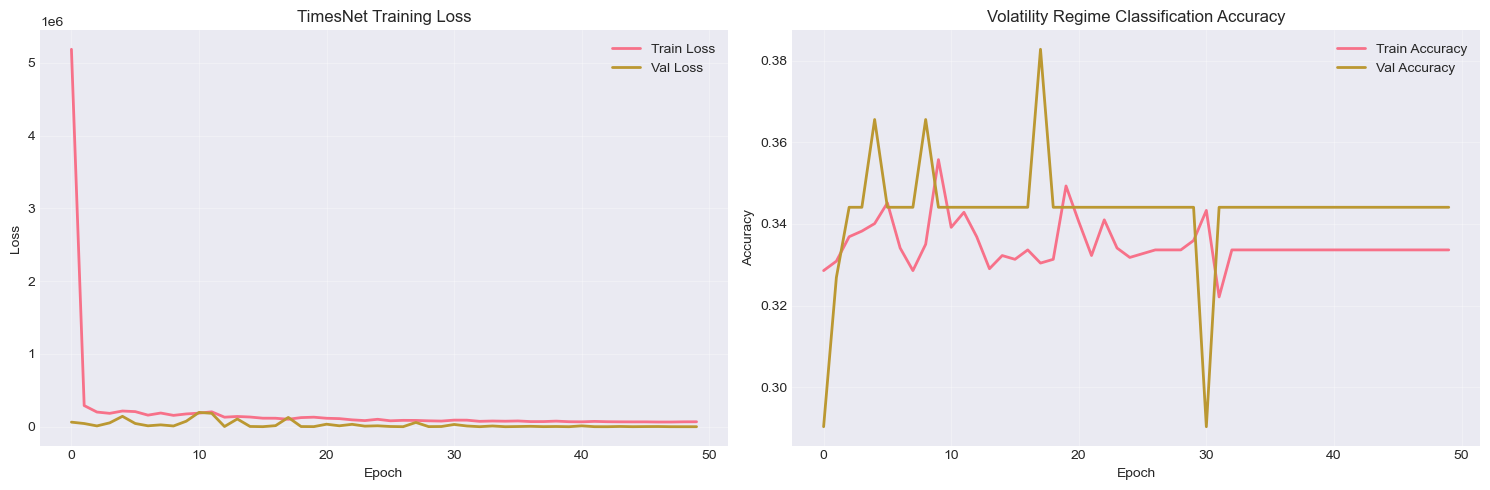

In [19]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(val_history['loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('TimesNet Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(val_history['accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Volatility Regime Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Test Set Performance:
  Forecast MSE: 1203.7723
  Forecast RMSE: 34.6954
  Classification Accuracy: 29.89%


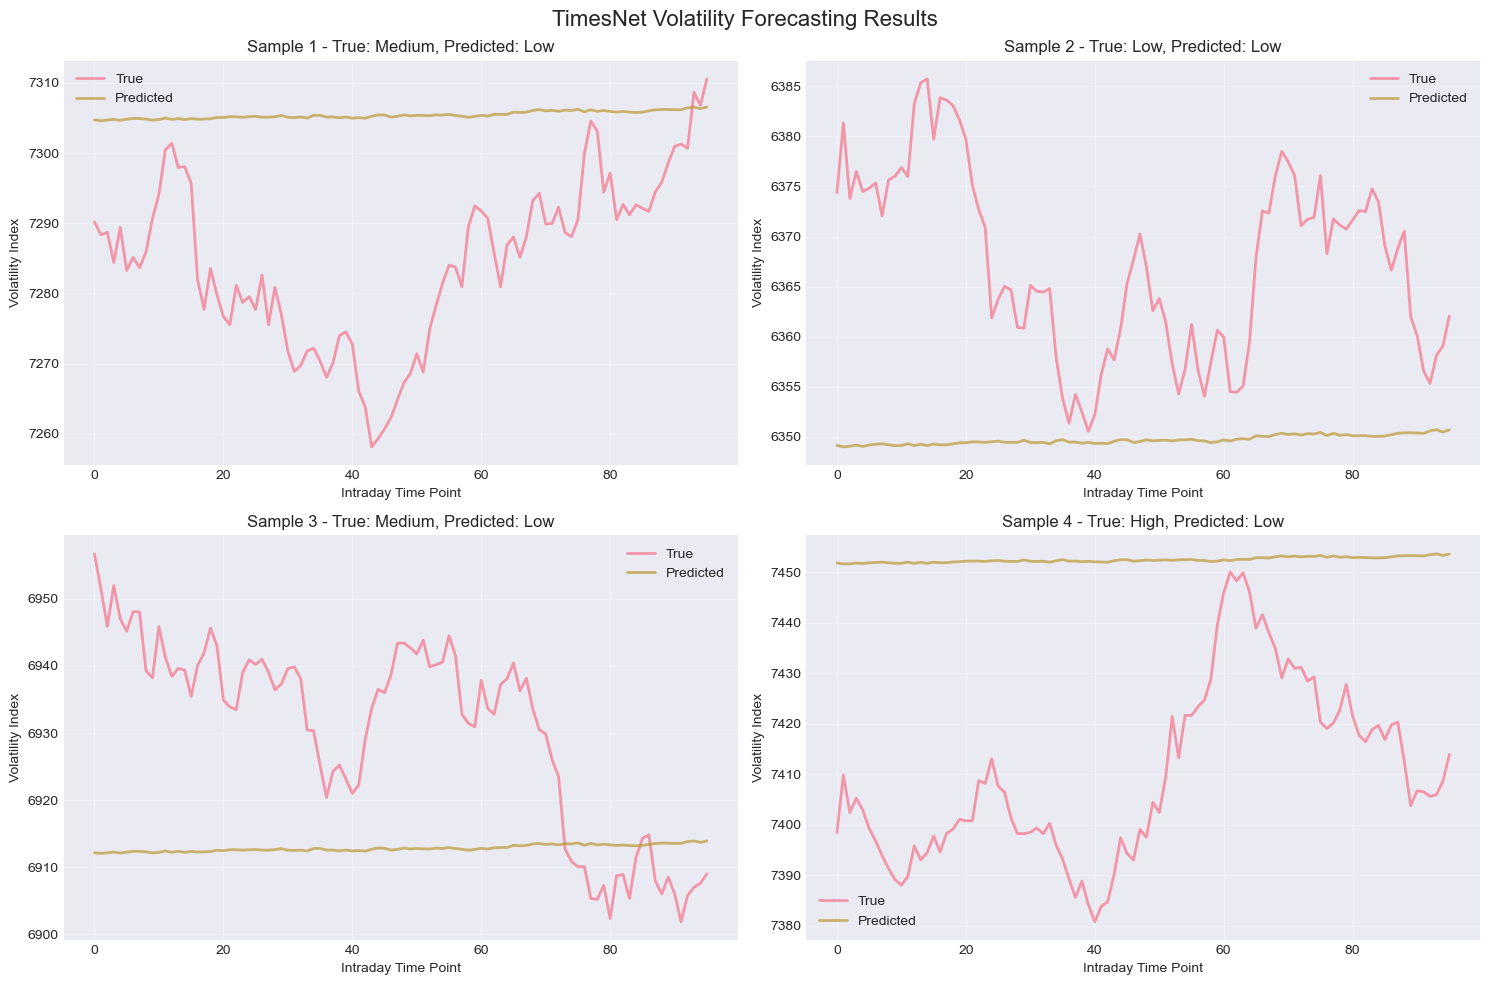

In [20]:
# Test the model
test_metrics = evaluate(model, test_loader, device)
print("Test Set Performance:")
print(f"  Forecast MSE: {test_metrics['forecast_loss']:.4f}")
print(f"  Forecast RMSE: {np.sqrt(test_metrics['forecast_loss']):.4f}")
print(f"  Classification Accuracy: {test_metrics['accuracy']:.2%}")

# Get sample predictions for visualization
model.eval()
with torch.no_grad():
    # Get one batch
    x_sample, y_true_forecast, y_true_class = next(iter(test_loader))
    x_sample = x_sample.to(device)
    
    # Predict
    outputs = model(x_sample)
    y_pred_forecast = outputs['forecast'].cpu().numpy()
    y_pred_class = torch.argmax(outputs['classification'], dim=1).cpu().numpy()

# Visualize forecasting results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 4 example forecasts
for i in range(4):
    ax = axes[i // 2, i % 2]
    
    # Plot true vs predicted
    ax.plot(y_true_forecast[i].numpy(), label='True', alpha=0.7, linewidth=2)
    ax.plot(y_pred_forecast[i], label='Predicted', alpha=0.7, linewidth=2)
    
    # Add regime classification
    regime_names = ['Low', 'Medium', 'High']
    true_regime = regime_names[y_true_class[i]]
    pred_regime = regime_names[y_pred_class[i]]
    
    ax.set_title(f'Sample {i+1} - True: {true_regime}, Predicted: {pred_regime}')
    ax.set_xlabel('Intraday Time Point')
    ax.set_ylabel('Volatility Index')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('TimesNet Volatility Forecasting Results', fontsize=16)
plt.tight_layout()
plt.show()

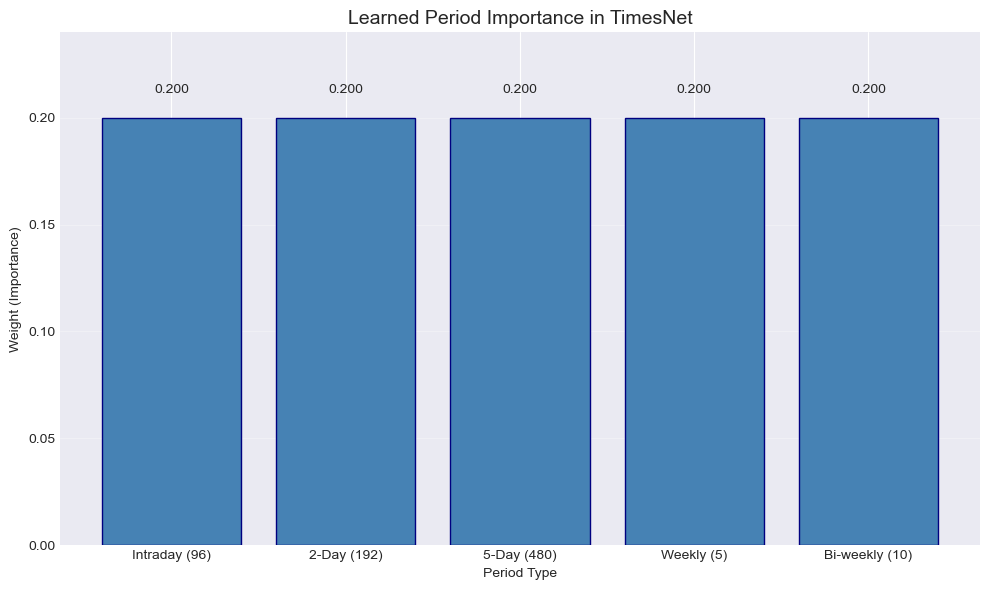

Period Analysis:
  Intraday (96): 0.200 (20.0%)
  2-Day (192): 0.200 (20.0%)
  5-Day (480): 0.200 (20.0%)
  Weekly (5): 0.200 (20.0%)
  Bi-weekly (10): 0.200 (20.0%)


In [21]:
# Extract and visualize learned period weights
model.eval()

# Get period weights from first TimesBlock
period_weights = model.blocks[0].period_weights.detach().cpu().numpy()
period_weights = np.exp(period_weights) / np.sum(np.exp(period_weights))  # Softmax

periods = [96, 192, 480, 5, 10]
period_labels = ['Intraday (96)', '2-Day (192)', '5-Day (480)', 
                 'Weekly (5)', 'Bi-weekly (10)']

plt.figure(figsize=(10, 6))
bars = plt.bar(period_labels, period_weights, color='steelblue', edgecolor='navy')
plt.title('Learned Period Importance in TimesNet', fontsize=14)
plt.xlabel('Period Type')
plt.ylabel('Weight (Importance)')
plt.ylim([0, max(period_weights) * 1.2])

# Add value labels on bars
for bar, weight in zip(bars, period_weights):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{weight:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Period Analysis:")
for label, weight in zip(period_labels, period_weights):
    print(f"  {label}: {weight:.3f} ({weight*100:.1f}%)")